<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/PET_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [1]:
import os
import glob
import random
import json
import warnings
from collections import defaultdict
from monai.transforms import (EnsureChannelFirstd, Compose, LoadImaged, Spacingd, Resized)
from monai.data import CacheDataset, DataLoader
import numpy as np
import random
from collections import defaultdict
from monai.data import Dataset
from monai.utils import first, set_determinism
import matplotlib.pyplot as plt
import torch
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd
from utils import ids

In [2]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
ga_output_dir = config["ga_output_dir"]
artifact_dir = config["artifacts"]
artifact_output = config ["artifact_output"]
fdg_output_dir = config['fdg_output_dir']


## Set dataset path

In [3]:
from data_preparation import DataHandling 

data_handler = DataHandling(ga_data_dir, train_mode="NAC", target_mode="MAC")

train_files = data_handler.get_data_split('train')
val_files = data_handler.get_data_split('val')
test_files = data_handler.get_data_split('test')
print(len(train_files))
print(len(val_files))
print(len(test_files))

from data_preparation import LoaderFactory
loader_factory = LoaderFactory(
    train_files=train_files,
    val_files=val_files,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    # spacing = [1.92, 1.92, 3.27], # For fdg data
    spatial_size = (168, 168, 400)
    # spatial_size = (336, 336, 640) # for Fdg data
    )

test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)

# To access 'image' keys, iterate through the list
image_files = [file_info['image'] for file_info in test_files]
target_files = [file_info['target'] for file_info in test_files]

129
33
20


In [3]:

from data_preparation import ExternalRadioSetHandling

data_handler = ExternalRadioSetHandling(data_dir=fdg_data_dir, test_ratio=1)
train_files, val_files, test_files = data_handler.get_split_data()

print(f"Test data length: {len(test_files)}")
print(f"Validation data length: {len(val_files)}")
print(f"Train data length: {len(train_files)}")

# To access 'image' keys, iterate through the list
image_files = [file_info['image'] for file_info in test_files]
target_files = [file_info['target'] for file_info in test_files]
print(len(image_files))


Test data length: 98
Validation data length: 0
Train data length: 0
98


-------------
# Reset THe header

In [ ]:
# import nibabel as nib
# import os

# def reset_origin_and_save(image_paths):
#     for image_path in image_paths:
#         try:
#             img = nib.load(image_path)
#             img_data = img.get_fdata()
#             new_affine = img.affine.copy()
#             new_affine[:3, 3] = 0
#             new_affine[1, 1] = -abs(new_affine[1, 1])
#             new_img = nib.Nifti1Image(img_data, new_affine, header=img.header)
#             new_image_path = image_path #.replace('.nii', '_origin_reset.nii').replace('.gz', '_origin_reset.gz')
#             nib.save(new_img, new_image_path)
#             print(f"Processed: {image_path}")
#         except Exception as e:
#             print(f"Failed to process {image_path}: {e}")

# reset_origin_and_save(image_files)
# reset_origin_and_save(target_files)


In [ ]:
# import nibabel as nib
# import numpy as np
# import os

# def save_image_with_new_header(image_paths):
#     for image_path in image_paths:
#         # Load the original image
#         img = nib.load(image_path)
#         img_data = img.get_fdata()
#         print(f"Original affine matrix for {os.path.basename(image_path)}:\n{img.affine}\n")

#         new_affine = img.affine.copy()
#         new_affine[:3, 3] = 0  # Set the translation part of the affine matrix to 0
        
#         # Create a new NIfTI image with the updated affine matrix
#         new_img = nib.Nifti1Image(img.get_fdata(), new_affine, header=img.header)
        
#         # Save the new image
#         new_image_path = image_path.replace('.nii.gz', 'reset.nii.gz')
#         nib.save(new_img, new_image_path)
        
#         # Print the updated affine matrix
#         print(f"Updated affine matrix for {os.path.basename(new_image_path)}:\n{new_img.affine}\n")

# # Resetting the origin and affine matrix for images
# save_image_with_new_header(image_files)
# save_image_with_new_header(target_files)


-----------------

# Data Visualization

In [4]:
test_name = [(os.path.splitext(os.path.splitext(os.path.basename(file_info['image']))[0])[0], 
              os.path.splitext(os.path.splitext(os.path.basename(file_info['target']))[0])[0]) 
             for file_info in test_files]
test_name

[('006009_dataset_07_A', '006009_dataset_07_A'),
 ('005081_dataset_06_A_nac_6', '005081_dataset_06_A_nac_6'),
 ('006056_dataset_07_A', '006056_dataset_07_A'),
 ('005035_dataset_06_A', '005035_dataset_06_A'),
 ('006036_dataset_07_A', '006036_dataset_07_A'),
 ('006038_dataset_07_A', '006038_dataset_07_A'),
 ('006011_dataset_07_A', '006011_dataset_07_A'),
 ('005085_dataset_06_A_nac_6', '005085_dataset_06_A_nac_6'),
 ('005019_dataset_06_A', '005019_dataset_06_A'),
 ('005001_dataset_06_A', '005001_dataset_06_A'),
 ('005065_dataset_06_A', '005065_dataset_06_A'),
 ('006025_dataset_07_A', '006025_dataset_07_A'),
 ('005096_dataset_06_A_nac_6', '005096_dataset_06_A_nac_6'),
 ('005049_dataset_06_A_nac_3', '005049_dataset_06_A_nac_3'),
 ('005091_dataset_06_A_nac_6', '005091_dataset_06_A_nac_6'),
 ('005008_dataset_06_A', '005008_dataset_06_A'),
 ('005041_dataset_06_A_nac_3', '005041_dataset_06_A_nac_3'),
 ('005021_dataset_06_A', '005021_dataset_06_A'),
 ('006048_dataset_07_A', '006048_dataset_07_A'

In [ ]:
# test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]
# import nibabel as nib
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# from skimage import exposure

# from skimage import exposure, img_as_float

# def load_and_normalize_nifti(path):
#     """Load a NIFTI file and normalize its data."""
#     img = nib.load(path).get_fdata()
#     img = img_as_float(img)  # Normalize image to float in the range [0, 1]
#     return img

# for file_info, name_pair in zip(test_files, test_name):
#     image_path = file_info['image']
#     target_path = file_info['target']

#     # Load and normalize images
#     image = load_and_normalize_nifti(image_path)
#     target = load_and_normalize_nifti(target_path)

#     # Extract the patient folder name from the file path
#     patient_folder_name_image, patient_folder_name_target = name_pair
#     # Let's say you want to display the middle slice for each image/target
#     n = image.shape[0] // 2  # Assuming the third dimension is the 'slice' dimension

#     plt.figure(figsize=(7, 12))  # Correct way to set figure size
#     plt.subplot(1, 2, 1)
#     plt.title(f"{patient_folder_name_image}")
#     # Rotate the slice and plot
#     input_slice = np.rot90(image[:, n, :])
#     plt.imshow(input_slice, cmap="BuPu")

#     plt.subplot(1, 2, 2)
#     plt.title(f"{patient_folder_name_target}")
#     # Rotate the slice and plot
#     target_slice = np.rot90(target[:, n, :])
#     plt.imshow(target_slice, cmap='BuPu')

#     plt.show()
#     # Display the plot
#     plt.show()




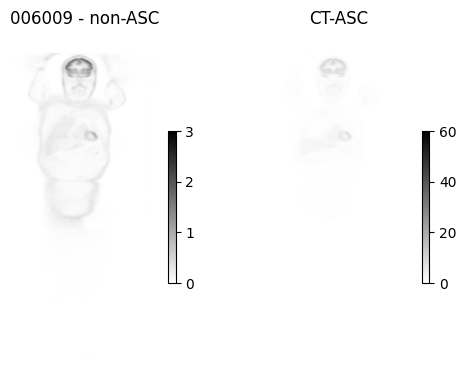

In [6]:
import nibabel as nib
import matplotlib.pyplot as plt
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]

pixel_spacing_mm = 0.9  # Replace with actual pixel spacing in mm
pixel_spacing_inch = pixel_spacing_mm / 25.4  # Convert mm to inches

# Get image dimensions in pixels (replace with actual image dimensions)
image_width_px, image_height_px = 256, 256  # Example dimensions

# Calculate the size of the image in inches
image_width_inch = image_width_px * pixel_spacing_inch
image_height_inch = image_height_px * pixel_spacing_inch

# Now use these dimensions to set the figure size and DPI
dpi = 100  # You can adjust this value to your screen for an accurate size representation
figsize = (image_width_inch, image_height_inch/2)


for i, file_info in enumerate(test_files):
    image_path = file_info['image']
    target_path = file_info['target']
    
    image = nib.load(image_path).get_fdata() * 2
    target = nib.load(target_path).get_fdata() * 5
    patient_folder_name = os.path.basename(os.path.dirname(image_path))

    # Assuming the second dimension is the 'slice' dimension; adjust as necessary
    n = 90  

    plt.figure(figsize=(6, 4))  # Adjust figure size as needed

    # Plot the input image slice
    plt.subplot(1, 2, 1)
    plt.title(f"{ids(test_name[i][0])} - non-ASC\n")
    input_slice = np.rot90(image[:, n, :])  # Rotate the slice to correct orientation
    im_input = plt.imshow(input_slice, cmap="binary", vmax= 3, vmin=0)
    plt.colorbar(im_input, fraction=0.036, pad=0.04)  # Add colorbar for the input image slice
    plt.axis('off')
    # Plot the target image slice
    plt.subplot(1, 2, 2)
    plt.title("CT-ASC\n")
    target_slice = np.rot90(target[:, n, :])  # Rotate the slice to correct orientation
    im_target = plt.imshow(target_slice, cmap='binary',  vmax= 60, vmin=0)
    plt.colorbar(im_target, fraction=0.036, pad=0.04)  # Add colorbar for the target image slice
    plt.axis('off')
    plt.show()
    break



-------

# The Image Dimension

In [7]:
from monai.transforms import LoadImage

loader = LoadImage(image_only=True)

# Iterate through each pair of image and target
for image_path, target_path in zip(image_files, target_files):
    # Load the image and target
    image = loader(image_path)
    target = loader(target_path)
    
    # Print the size information of the image and target
    print(f"Image Size: {image.shape},  {image_path},")
    print(f"Target Size: {target.shape}, {target_path},\n")


Image Size: torch.Size([272, 200, 560]),  /students/2023-2024/master/Shahpouri/DATA/FDG-PET/NAC/006009_dataset_07_A.nii.gz,
Target Size: torch.Size([272, 200, 560]), /students/2023-2024/master/Shahpouri/DATA/FDG-PET/MAC/006009_dataset_07_A.nii.gz,

Image Size: torch.Size([272, 200, 283]),  /students/2023-2024/master/Shahpouri/DATA/FDG-PET/NAC/005081_dataset_06_A_nac_6.nii.gz,
Target Size: torch.Size([272, 200, 283]), /students/2023-2024/master/Shahpouri/DATA/FDG-PET/MAC/005081_dataset_06_A_nac_6.nii.gz,

Image Size: torch.Size([272, 200, 599]),  /students/2023-2024/master/Shahpouri/DATA/FDG-PET/NAC/006056_dataset_07_A.nii.gz,
Target Size: torch.Size([272, 200, 599]), /students/2023-2024/master/Shahpouri/DATA/FDG-PET/MAC/006056_dataset_07_A.nii.gz,

Image Size: torch.Size([272, 200, 295]),  /students/2023-2024/master/Shahpouri/DATA/FDG-PET/NAC/005035_dataset_06_A.nii.gz,
Target Size: torch.Size([272, 200, 295]), /students/2023-2024/master/Shahpouri/DATA/FDG-PET/MAC/005035_dataset_06_A.n

In [6]:
import nibabel as nib

# Function to read patient-specific information from NIfTI headers
def read_patient_info(nifti_file):
    # Load the NIfTI file
    nii = nib.load(nifti_file)
    header = nii.header
    
    # Example of accessing standard header information
    print("Header Keys:", header.keys())
    print("Pixel Dimensions:", header['pixdim'])
    
    # Custom tags need to be known and accessed directly
    # Let's assume 'weight' and 'dose' are stored in the description field or elsewhere
    description = header.get('descrip').item().decode('utf-8')  # you may need to decode from bytes to string
    print("Description:", description)
    
    # If you've added custom metadata in a predictable format, parse it:
    # Example: description might contain "weight:70;dose:5"
    metadata = dict(item.split(":") for item in description.split(";") if ":" in item)
    return metadata

# Iterate through each image file
for image_path in image_files:
    info = read_patient_info(image_path)
    print(f"Metadata for {image_path}:", info)


Header Keys: ['sizeof_hdr', 'data_type', 'db_name', 'extents', 'session_error', 'regular', 'dim_info', 'dim', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'pixdim', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'descrip', 'aux_file', 'qform_code', 'sform_code', 'quatern_b', 'quatern_c', 'quatern_d', 'qoffset_x', 'qoffset_y', 'qoffset_z', 'srow_x', 'srow_y', 'srow_z', 'intent_name', 'magic']
Pixel Dimensions: [1.      4.07283 4.07283 3.      0.      0.      0.      0.     ]
Description: 
Metadata for /students/2023-2024/master/Shahpouri/DATA/Ga-PET/NAC/001414_C1_RZ_.nii.gz: {}
Header Keys: ['sizeof_hdr', 'data_type', 'db_name', 'extents', 'session_error', 'regular', 'dim_info', 'dim', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'pixdim', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'sl

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage

loader = LoadImage(image_only=True)

# Function to plot histogram
def plot_histogram(data, title):
    plt.figure()
    plt.hist(data, bins=100, color='c', alpha=0.75)
    plt.title(f'Total Histogram for {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Function to collect all pixel values from a list of files
def collect_pixel_values(file_list):
    all_pixels = []
    for file_path in file_list:
        image = loader(file_path)
        all_pixels.extend(image.flatten())  # Flatten the image and add pixels to the list
    return np.array(all_pixels)

# Collecting all pixel values for NAC and MAC images
nac_pixels = collect_pixel_values(image_files)
mac_pixels = collect_pixel_values(target_files)

# Plot histogram for all NAC images
plot_histogram(nac_pixels, 'NAC Images')

# Plot histogram for all MAC images
plot_histogram(mac_pixels, 'MAC Images')


: 

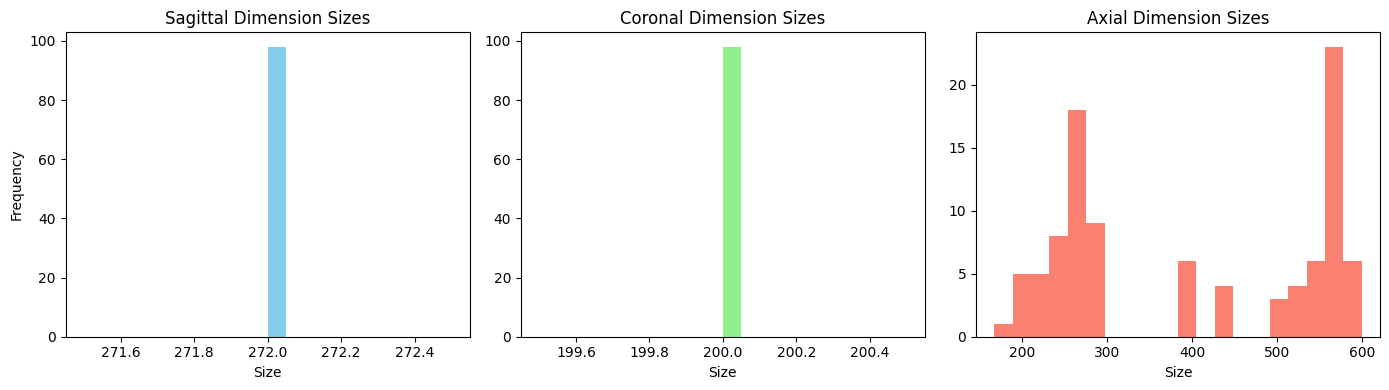

In [ ]:
from monai.transforms import LoadImage
import matplotlib.pyplot as plt

# Assuming val_files is a list of dictionaries with 'image' keys
image_sizes = []
loader = LoadImage(image_only=True)

# Collect image sizes
for file_info in image_files:
    image = loader(file_info)
    image_sizes.append(image.shape)

# Extracting dimensions
dims1 = [size[0] for size in image_sizes]
dims2 = [size[1] for size in image_sizes]
dims3 = [size[2] for size in image_sizes]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].hist(dims1, bins=20, color='skyblue')
axs[0].set_title('Sagittal Dimension Sizes')
axs[0].set_xlabel('Size')
axs[0].set_ylabel('Frequency')

axs[1].hist(dims2, bins=20, color='lightgreen')
axs[1].set_title('Coronal Dimension Sizes')
axs[1].set_xlabel('Size')

axs[2].hist(dims3, bins=20, color='salmon')
axs[2].set_title('Axial Dimension Sizes')
axs[2].set_xlabel('Size')

plt.tight_layout()
plt.show()


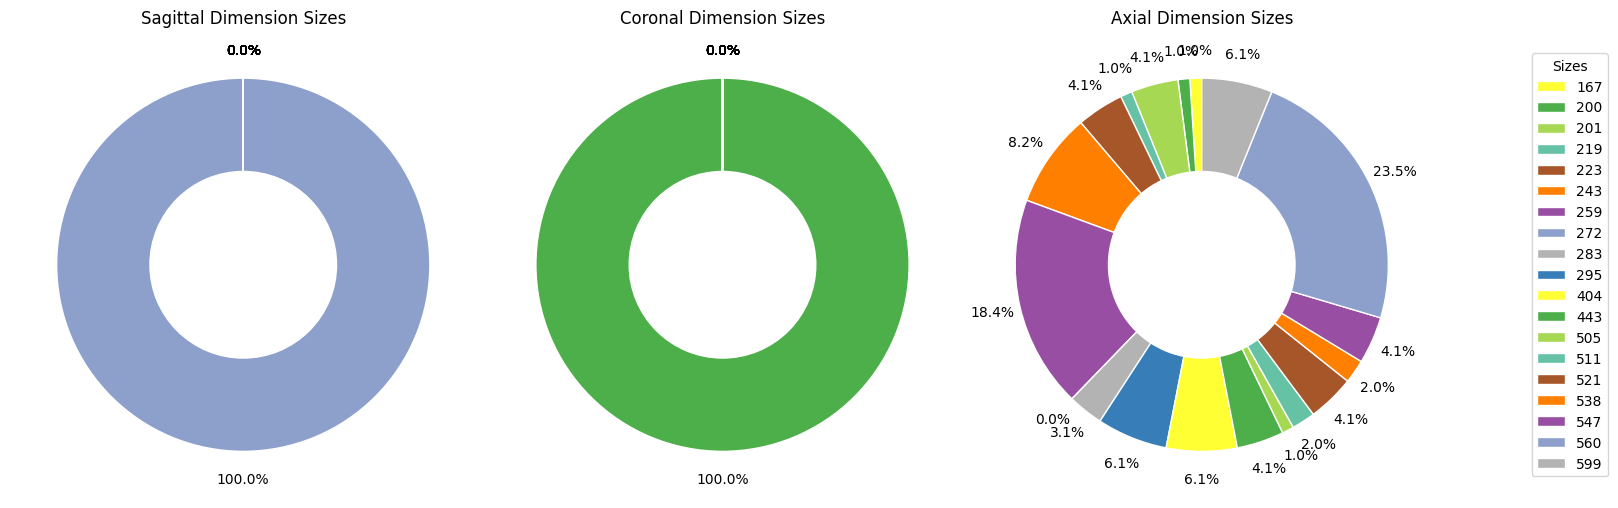

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

dim1_counts = Counter(dims1)
dim2_counts = Counter(dims2)
dim3_counts = Counter(dims3) 

# Combine all counts to create a unified color reference
all_dims = list(set(dims1 + dims2 + dims3))
all_dims.sort()

# Define the number of colors you need from each colormap
n_set2_colors = 10
n_accent_colors = 10

# Get the colors from the 'Set2' and 'Accent' colormaps
set2_colors = plt.cm.Set2(np.linspace(0, 1, n_set2_colors))
accent_colors = plt.cm.Set1(np.linspace(0, 1, n_accent_colors))
# Concatenate the two sets of colors
all_colors = np.vstack((set2_colors, accent_colors))

# Randomly select 10 unique colors from each of the two colormaps

random_indices = np.random.choice(len(all_colors), size=10, replace=False)
custom_palette = all_colors[random_indices]

# Create subplots for donut plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Function to create a donut plot
def create_donut_plot(ax, data_counts, title):
    labels = [str(k) for k in all_dims]  # Use all dimensions for labels
    sizes = [data_counts[k] if k in data_counts else 0 for k in all_dims]
    wedges, texts, autotexts = ax.pie(sizes, labels=None, autopct='%1.1f%%',
                                      startangle=90, wedgeprops=dict(width=0.5, edgecolor='w'),
                                      colors=custom_palette, pctdistance=1.15)

    ax.set_title(title)
    return wedges

wedges1 = create_donut_plot(axs[0], dim1_counts, 'Sagittal Dimension Sizes')
create_donut_plot(axs[1], dim2_counts, 'Coronal Dimension Sizes')
create_donut_plot(axs[2], dim3_counts, 'Axial Dimension Sizes')

# Add a common legend
fig.legend(wedges1, [str(k) for k in all_dims], title="Sizes", loc='center right', bbox_to_anchor=(0.9, 0.5))

plt.tight_layout()
plt.subplots_adjust(right=0.8)  # Adjust this to fit the legend if necessary
plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import Counter


# # Count occurrences
# dim1_counts = Counter(dims1)
# dim2_counts = Counter(dims2)
# dim3_counts = Counter(dims3) 

# # Combine the 'Set2' and 'Accent' color palettes
# set2_palette = plt.cm.Set2(np.linspace(0, 1, 10))  # 'Set2' has 8 colors
# accent_palette = plt.cm.Accent(np.linspace(0, 1, 4))  # 'Accent' has 4 colors
# custom_palette = np.vstack((set2_palette, accent_palette))

# # Ensure we have a color for each unique size in dims1 and dims2
# unique_sizes = sorted(set(dims1 + dims3))
# color_indices = np.random.choice(len(custom_palette), size=len(unique_sizes), replace=False)
# size_to_color = {size: custom_palette[idx] for size, idx in zip(unique_sizes, color_indices)}

# # Create the donut plots
# fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# def create_donut_plot(ax, counts, title):
#     sizes = [counts[size] for size in unique_sizes if size in counts]
#     colors = [size_to_color[size] for size in unique_sizes if size in counts]
#     wedges, texts, autotexts = ax.pie(sizes, labels=None, autopct='%1.1f%%',
#                                       startangle=90, wedgeprops=dict(width=0.5, edgecolor='w'),
#                                       colors=colors, pctdistance=1.15)
#     ax.set_title(title)
#     return wedges

# create_donut_plot(axs[0], dim1_counts, 'Sagittal Dimension Sizes')
# create_donut_plot(axs[1], dim2_counts, 'Coronal Dimension Sizes')
# create_donut_plot(axs[2], dim3_counts, 'Axial Dimension Sizes')

# # Draw a single legend for unique sizes
# handles, labels = [], []
# for size in unique_sizes:
#     handles.append(plt.Rectangle((0, 0), 1, 1, fc=size_to_color[size]))
#     labels.append(str(size))

# fig.legend(handles, labels, title="Sizes", loc='center right', bbox_to_anchor=(0.9, 0.5))

# plt.tight_layout()
# plt.subplots_adjust(right=0.75)  # Adjust as needed
# plt.show()


In [ ]:
# def print_image_info(file_info, transforms):
#     loader = LoadImage(image_only=True)
#     image = loader(file_info['image'])
#     print(f"Original image size: {image.shape}")
    
#     # Apply transformations
#     transformed_image = transforms(file_info)
#     print(f"Transformed image size: {transformed_image['image'].shape}")

# # Define your transforms
# train_transforms = Compose([
#     LoadImaged(keys=["image", "target"]),
#     EnsureChannelFirstd(keys=["image", "target"]),
#     Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
#     SpatialPadd(keys=["image", "target"], spatial_size=[96, 96, 96], mode='constant', method='symmetric'),
# ])

# # # Example usage
# # print("Train Files:")
# # for file_info in train_files[-5:]:  # Adjust the number as needed
# #     print_image_info(file_info, train_transforms)

# print("\nValidation Files:")
# for file_info in val_files[-5:]:  # Adjust the number as needed
#     print_image_info(file_info, train_transforms)


-------------
# Check voxel spacing

In [9]:
from monai.transforms import LoadImage
import numpy as np

def get_voxel_spacing(file_path):
    loader = LoadImage(image_only=False)  # Load image and metadata
    _, meta_data = loader(file_path)
    # The first element of 'pixdim' is often 1 and not used for spacing,
    # so we take the next three elements which represent the voxel spacings in X, Y, and Z.
    spacing = meta_data['pixdim'][1:4]  # Extract voxel spacing from 'pixdim'
    return spacing


voxel_spacings = np.array([get_voxel_spacing(file_info) for file_info in image_files])

print(voxel_spacings)





[[1.92      1.92      3.       ]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.       ]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.       ]
 [1.92      1.92      3.       ]
 [1.92      1.92      3.       ]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.2699585]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.       ]
 [1.92      1.92      3.2700195]
 [1.92      1.92      4.25     ]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.2699585]
 [1.92      1.92      4.25     ]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.       ]
 [1.92      1.92      3.       ]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.       ]
 [1.92      1.92      3.       ]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.       ]
 [1.92      1.92      3.2700195]
 [1.92      1.92      3.       ]
 [1.92    

In [10]:
from monai.transforms import LoadImage
import numpy as np
import warnings  # To issue warnings


def check_voxel_spacing_mismatch(image_files, target_files):
    if len(image_files) != len(target_files):
        raise ValueError("Number of image files and target files must be the same.")
    
    for i, (image_path, target_path) in enumerate(zip(image_files, target_files)):
        image_spacing = get_voxel_spacing(image_path)
        target_spacing = get_voxel_spacing(target_path)
        
        if not np.allclose(image_spacing, target_spacing):
            warnings.warn(f"Voxel spacing mismatch between image and target at index {i}: {image_path} vs {target_path}")



check_voxel_spacing_mismatch(image_files, target_files)

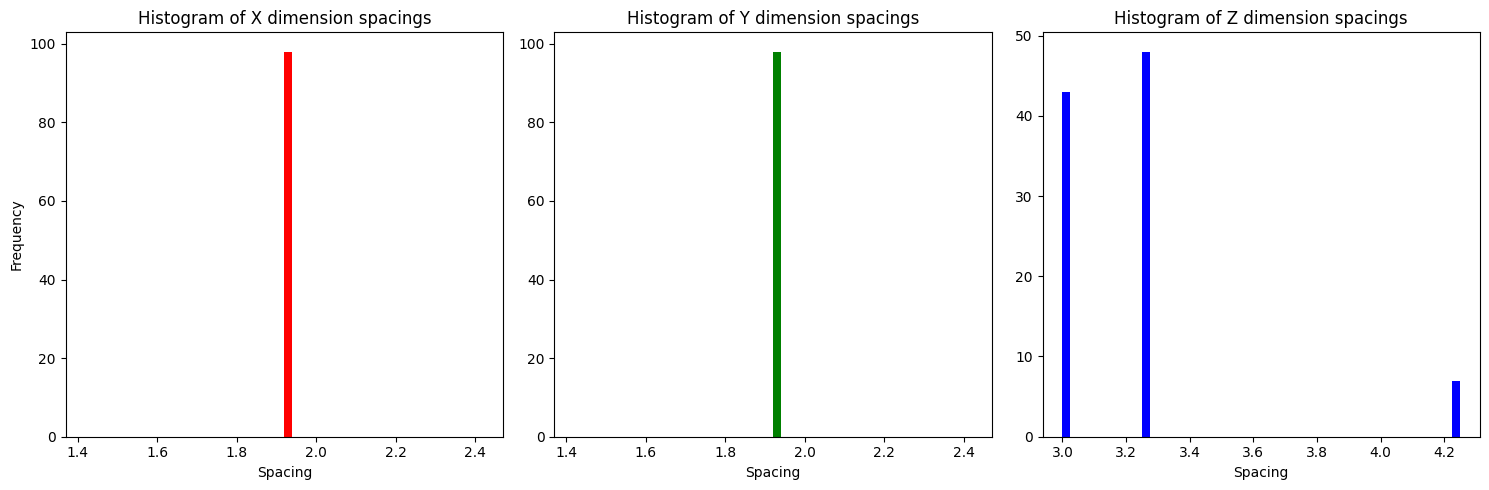

In [11]:
# Assuming voxel_spacings is an Nx3 array where N is the number of images, and each row is the spacing (x, y, z)
plt.figure(figsize=(15, 5))

# X dimension spacings
plt.subplot(1, 3, 1)
plt.hist(voxel_spacings[:, 0], bins=50, color='r')
plt.title('Histogram of X dimension spacings')
plt.xlabel('Spacing')
plt.ylabel('Frequency')

# Y dimension spacings
plt.subplot(1, 3, 2)
plt.hist(voxel_spacings[:, 1], bins=50, color='g')
plt.title('Histogram of Y dimension spacings')
plt.xlabel('Spacing')

# Z dimension spacings
plt.subplot(1, 3, 3)
plt.hist(voxel_spacings[:, 2], bins=50, color='b')
plt.title('Histogram of Z dimension spacings')
plt.xlabel('Spacing')

plt.tight_layout()
plt.show()


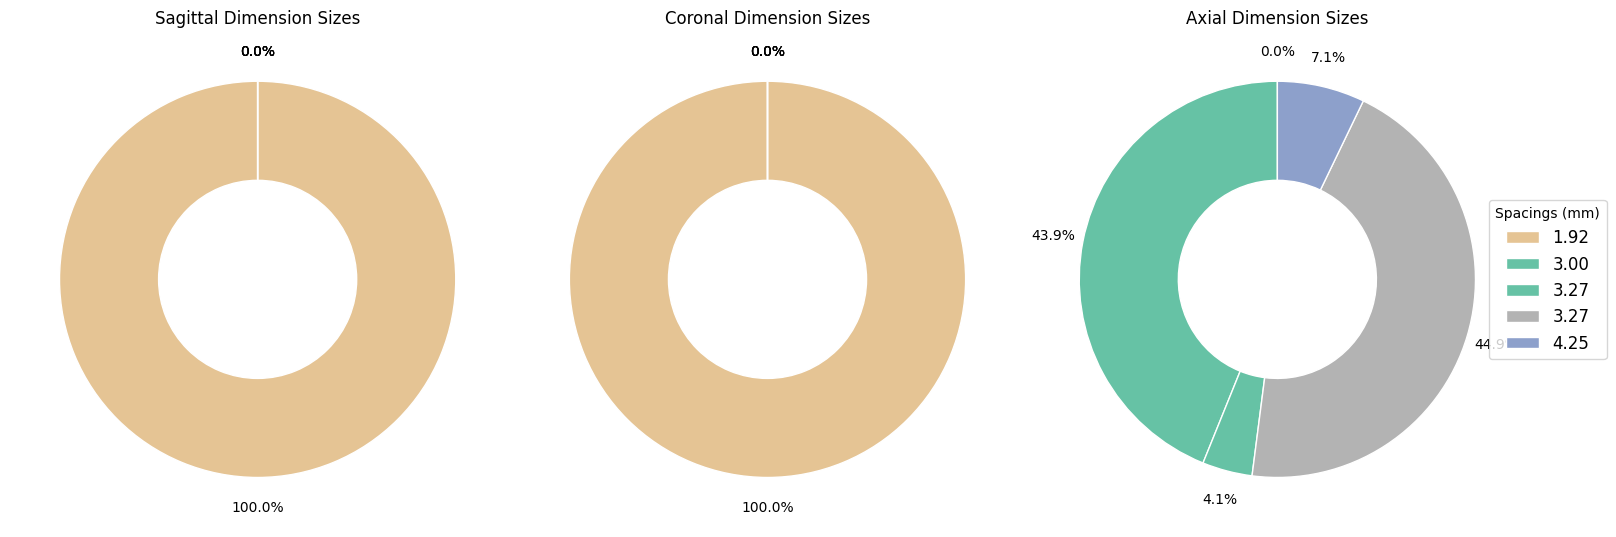

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


# Count occurrences of each spacing value in each dimension
spacing_counts_x = Counter(voxel_spacings[:, 0])
spacing_counts_x = Counter(voxel_spacings[:, 1])
spacing_counts_z = Counter(voxel_spacings[:, 2])

all_dims = list(set(spacing_counts_x + spacing_counts_x + spacing_counts_z))
all_dims.sort()

# Define the number of colors you need from each colormap
n_set2_colors = 10
n_accent_colors = 0

# Get the colors from the 'Set2' and 'Accent' colormaps
set2_colors = plt.cm.Set2(np.linspace(0, 1, n_set2_colors))
accent_colors = plt.cm.Set1(np.linspace(0, 1, n_accent_colors))
# Concatenate the two sets of colors
all_colors = np.vstack((set2_colors, accent_colors))

# Randomly select 10 unique colors from each of the two colormaps

random_indices = np.random.choice(len(all_colors), size=6, replace=False)
custom_palette = all_colors[random_indices]

# Function to create a donut plo
    

# Create subplots for donut plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Function to create a donut plot
def create_donut_plot(ax, data_counts, title):
    labels = [str(k) for k in all_dims]  # Use all dimensions for labels
    sizes = [data_counts[k] if k in data_counts else 0 for k in all_dims]
    wedges, texts, autotexts = ax.pie(sizes, labels=None, autopct='%1.1f%%',
                                      startangle=90, wedgeprops=dict(width=0.5, edgecolor='w'),
                                      colors=custom_palette, pctdistance=1.15)

    ax.set_title(title)
    return wedges

wedges1 = create_donut_plot(axs[0], spacing_counts_x, 'Sagittal Dimension Sizes')
create_donut_plot(axs[1], spacing_counts_x, 'Coronal Dimension Sizes')
create_donut_plot(axs[2], spacing_counts_z, 'Axial Dimension Sizes')

# Add a common legend
fig.legend(wedges1, [f"{k:.2f}" for k in all_dims], title="Spacings (mm)", loc='center right', 
           bbox_to_anchor=(0.9, 0.5), fontsize='large')
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Adjust as needed
plt.show()


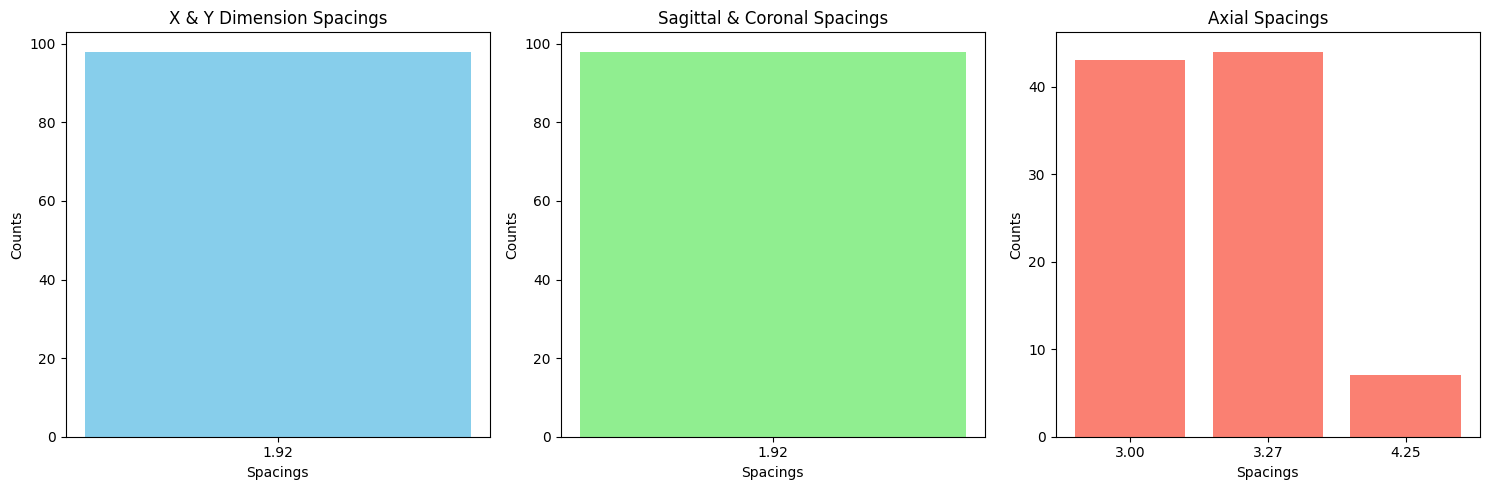

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming voxel_spacings is a numpy array with the voxel spacing in each dimension
x_spacing_counts = np.unique(voxel_spacings[:, 0], return_counts=True)
y_spacing_counts = np.unique(voxel_spacings[:, 1], return_counts=True)
z_spacing_counts = np.unique(voxel_spacings[:, 2], return_counts=True)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Function to format the spacings with two decimal places
format_spacing = lambda spacings: [f'{spacing:.2f}' for spacing in spacings]

# X dimension spacings
axs[0].bar(format_spacing(x_spacing_counts[0]), x_spacing_counts[1], color='skyblue')
axs[0].set_title('X & Y Dimension Spacings')
axs[0].set_xlabel('Spacings')
axs[0].set_ylabel('Counts')

# Y dimension spacings
axs[1].bar(format_spacing(y_spacing_counts[0]), y_spacing_counts[1], color='lightgreen')
axs[1].set_title('Sagittal & Coronal Spacings')
axs[1].set_xlabel('Spacings')
axs[1].set_ylabel('Counts')

# Z dimension spacings
axs[2].bar(format_spacing(z_spacing_counts[0]), z_spacing_counts[1], color='salmon')
axs[2].set_title('Axial Spacings')
axs[2].set_xlabel('Spacings')
axs[2].set_ylabel('Counts')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import mode

# Since mode() returns a scalar, we no longer try to index it with [0]
most_common_spacing_x = mode(np.round(voxel_spacings[:, 0], decimals=2)).mode
most_common_spacing_y = mode(np.round(voxel_spacings[:, 1], decimals=2)).mode
most_common_spacing_z = mode(np.round(voxel_spacings[:, 2], decimals=2)).mode

print(f"Most common voxel spacing in X dimension: {most_common_spacing_x}")
print(f"Most common voxel spacing in Y dimension: {most_common_spacing_y}")
print(f"Most common voxel spacing in Z dimension: {most_common_spacing_z}")


-------------
# Test details

In [ ]:
from scipy.stats import mode
test_mode_result_x = mode(np.round(voxel_spacings[:, 0], decimals=2))
print("Mode Result X:", test_mode_result_x)
print("Mode X:", test_mode_result_x.mode)


In [ ]:
print("Mode Result X Shape:", test_mode_result_x.mode.shape)
print("Type of Mode Result X:", type(test_mode_result_x.mode))


In [ ]:
print("Voxel Spacings Shape:", voxel_spacings.shape)
print("Type of Voxel Spacings:", type(voxel_spacings))


In [ ]:
print("First Element:", voxel_spacings[0, :])


In [ ]:
most_common_spacing_x = np.round(voxel_spacings[:, 0], decimals=2)
mode_result_x = mode(most_common_spacing_x)
print("Most Common Spacing X:", mode_result_x.mode if mode_result_x.mode.size else "No mode found")


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


----------
# Pixel Values

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage

# Initialize a list to store all pixel values
all_pixel_values = []

# Assuming 'data_files' is a list of file paths for your dataset
for file_path in image_files:
    # Load the image
    image = LoadImage(image_only=True)(file_path)
    
    # Convert the image to a numpy array if it's not already
    image_np = np.array(image)
    
    # Flatten the image array to get a list of all pixel values in the image
    pixels = image_np.flatten()
    
    # Append these pixel values to the aggregate list
    all_pixel_values.extend(pixels)

# Convert the list of all pixel values to a numpy array
all_pixel_values_np = np.array(all_pixel_values)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_pixel_values_np contains all the pixel values from the dataset

# Calculate mean and max of the scaled pixel values
mean_value = np.mean(all_pixel_values_np)
max_value = np.max(all_pixel_values_np)

# Printing statistical information
print(f"Mean of scaled pixel values: {mean_value}")
print(f"Maximum of scaled pixel values: {max_value}")

# Plotting the histogram of scaled pixel values
plt.figure(figsize=(10, 6))
plt.hist(all_pixel_values_np, bins=50, color='green', alpha=0.7, density=True)
plt.title("Histogram of Scaled Pixel Values across the Dataset")
plt.xlabel("Scaled Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage


# Initialize LoadImage transform
loader = LoadImage(image_only=True)

for file_path in target_files:
    # Load the image
    image = loader(file_path)
    
    # Convert the image to a numpy array if it's not already
    image_np = np.array(image)
    
    # Calculate mean and max of the pixel values for the current image
    mean_value = np.mean(image_np)
    max_value = np.max(image_np)
    
    # Printing statistical information for each image
    print(f"File: {file_path}")
    print(f"Mean of pixel values: {mean_value}")
    print(f"Maximum of pixel values: {max_value}\n")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage

# Initialize a list to store all pixel values
all_pixel_values = []

# Assuming 'data_files' is a list of file paths for your dataset
for file_path in target_files:
    # Load the image
    image = LoadImage(image_only=True)(file_path)
    
    # Convert the image to a numpy array if it's not already
    image_np = np.array(image)
    
    # Flatten the image array to get a list of all pixel values in the image
    pixels = image_np.flatten()
    
    # Append these pixel values to the aggregate list
    all_pixel_values.extend(pixels)

# Convert the list of all pixel values to a numpy array
all_pixel_values_np = np.array(all_pixel_values)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_pixel_values_np contains all the pixel values from the dataset

# Calculate mean and max of the scaled pixel values
mean_value = np.mean(all_pixel_values_np)
max_value = np.max(all_pixel_values_np)

# Printing statistical information
print(f"Mean of scaled pixel values: {mean_value}")
print(f"Maximum of scaled pixel values: {max_value}")

# Plotting the histogram of scaled pixel values
plt.figure(figsize=(10, 6))
plt.hist(all_pixel_values_np, bins=50, color='green', alpha=0.7, density=True)
plt.title("Histogram of Scaled Pixel Values across the Dataset/ target")
plt.xlabel("Scaled Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

# Assuming you have two lists `image_files` and `target_files` which contain file paths to the images and targets, respectively
for image_path, target_path in zip(image_files, target_files):
    image = nib.load(image_path).get_fdata()
    target = nib.load(target_path).get_fdata()
    
    # Let's say you want to display the middle slice for each image/target
    n = image.shape[0] // 2  # Assuming the third dimension is the 'slice' dimension

    plt.figure(figsize=(12, 6))  # Correct way to set figure size
    plt.subplot(1, 2, 1)
    plt.title("Input")
    # Rotate the slice and plot
    input_slice = np.rot90(image[:, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 2, 2)
    plt.title("Ground truth")
    # Rotate the slice and plot
    target_slice = np.rot90(target[:, n, :])
    plt.imshow(target_slice, cmap='gist_yarg')

    plt.show()
    



In [ ]:

import numpy as np

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")


In [ ]:

n = 90  # Selecting the slice

plt.figure(figsize=(12, 6))  # Correct way to set figure size
plt.subplot(1, 2, 1)
plt.title("Input")
# Rotate the slice and plot
input_slice = np.rot90(image[:, n, :])
plt.imshow(input_slice, cmap="gist_yarg")

plt.subplot(1, 2, 2)
plt.title("Ground truth")
# Rotate the slice and plot
target_slice = np.rot90(target[:, n, :])
plt.imshow(target_slice, cmap='gist_yarg')

plt.show()


-------------
# Transformers

In [ ]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd
)


roi_size = [168, 168, 320]

val_transforms = Compose([
    LoadImaged(keys=["image", "target"]),
    EnsureChannelFirstd(keys=["image", "target"]),
    Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00)),  # Adjust spacing as needed
    SpatialPadd(keys=["image", "target"], spatial_size=(200, 200, 350), mode='constant',  method='symmetric'),  # Pad to ensure minimum size
    ScaleIntensityd(keys=["image", "target"], minv=0.0, maxv=1.0),
    CenterSpatialCropd(keys=["image", "target"], roi_size=roi_size),  # Crop to ensure exact size
])




train_ds = CacheDataset(data=train_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=1)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)



In [ ]:
# Load a few sample images from the train_loader and print their sizes
for i, batch_data in enumerate(train_loader):
    images = batch_data["image"]
    print(f"Batch {i} image size: {images.shape}")
    if i == 2:  # Adjust this to inspect more or fewer batches
        break

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from monai.data import DataLoader

# Assuming val_loader is already defined and loaded with your validation data
n = 95  # Selecting the slice

for i, data in enumerate(val_loader):
    image, target = (data["image"][0][0], data["target"][0][0])
    
    # Check if the selected slice index is within the bounds for the current image and target
    if n >= image.shape[1] or n >= target.shape[1]:  # Assuming the second dimension is the slice index
        print(f"Skipping patient {i+1}: slice index {n} is out of bounds for this patient.")
        continue

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Patient {i+1}: Input")
    input_slice = np.rot90(image[:, n, :])  # Adjust the slice index position if needed
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 2, 2)
    plt.title(f"Patient {i+1}: Ground truth")
    target_slice = np.rot90(target[:, n, :])  # Adjust the slice index position if needed
    plt.imshow(target_slice, cmap='gist_yarg')

    plt.show()


------------
# Apply transformers on test data


In [ ]:
# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensity
# from monai.inferers import SlidingWindowInferer

# # Assuming the same spacing and intensity normalization as training
# test_transforms = Compose([
#     LoadImaged(keys=["image"]),
#     EnsureChannelFirstd(keys=["image"]),
#     Spacingd(keys=["image"], pixdim=(4.07, 4.07, 3.0), mode=('bilinear')),
#     ScaleIntensity(keys=["image"]),  # Adjust based on your specific normalization used during training
#     # No need for SpatialPadd or cropping here
# ])

# # Sliding window inferer with the patch size used during training
# inferer = SlidingWindowInferer(roi_size=[96, 96, 96], sw_batch_size=1, overlap=0.5)

# # Assuming `model` is your trained model and `test_data` is a batch from your DataLoader
# test_data = next(iter(test_loader))  # Example to get a batch
# model.eval()
# with torch.no_grad():
#     # Apply transformations
#     test_data_transformed = test_transforms(test_data)
#     # Perform inference
#     preds = inferer(inputs=test_data_transformed["image"].unsqueeze(0), network=model)
#     # preds now contains the prediction for the whole volume


# **Create Model, Loss, Optimizer**

In [ ]:
import json
import torch
from torch import nn
from monai.networks.nets import UNet
from monai.networks.layers import Norm


model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [ ]:
max_epochs = 10
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []

In [ ]:


for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, targets = (batch_data["image"].to(device),
                           batch_data["target"].to(device),)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    train_losses.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_targets = (val_data["image"].to(device),
                                           val_data["target"].to(device),)
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_targets).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            val_losses.append(val_loss)
            print(f"Validation loss: {val_loss:.4f}")

            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_PET.pth"))
                print("Saved new best metric model")

print(f"Training completed. Best validation loss: {best_metric:.4f} at epoch {best_metric_epoch}")


In [ ]:
import numpy as np
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
plt.figure(figsize=(14, 6))  # Set the size of the figure

# Plotting the training and validation losses
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha = 0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 20))

plt.show()

In [ ]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_data["image"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"target")
    plt.imshow(val_data["target"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = val_outputs.detach().cpu()[0, 0, :, :, n]
    plt.imshow(output_slice, cmap="gist_yarg") # "gist_yarg")
    plt.show()


    # Load the best model state for visualization
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_PET.pth")))
model.eval()
roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(val_loader):

        n = 200
        visualize_results(val_data, model, n, f"Best Model")
        if i == 0:
            break




In [ ]:
#         if dice_after > best_eval_dice:
#             best_eval_dice = dice_after
#             if do_save:
#                 # Save best model based on Dice
#                 if pth_best_dice != "":
#                     os.remove(os.path.join(dir_save, pth_best_dice))
#                 pth_best_dice = f"segresnet_kpt_loss_best_dice_{epoch + 1}_{best_eval_dice:.3f}.pth"
#                 torch.save(model.state_dict(), os.path.join(dir_save, pth_best_dice))
#                 print(f"{epoch + 1} | Saving best Dice model: {pth_best_dice}")

#     if do_save:
#         # Save latest model
#         if pth_latest != "":
#             os.remove(os.path.join(dir_save, pth_latest))
#         pth_latest = "segresnet_kpt_loss_latest.pth"
#         torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))


# # learn2reg_nlst_paired_lung_CT notbook